In [1]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import itertools

In [2]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%pylab inline
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# book_filenames = sorted(glob.glob("*.txt"))

In [5]:
#/Users/pari/Developer/neuralNetwork_Tensorflow/text_emotion.csv
data = pd.read_csv("/Users/pari/Developer/neuralNetwork_Tensorflow/text_emotion.csv")

In [6]:
from nltk.stem.wordnet import WordNetLemmatizer 
lem = WordNetLemmatizer()

In [7]:
#comprehensive cleaning
def cleaning(text):
    txt = str(text)
    txt = re.sub(r"http\S+", "", txt)
    if len(txt) == 0:
        return 'no text'
    else:
        txt = txt.split()
        index = 0
        for j in range(len(txt)):
            if txt[j][0] == '@':
                index = j
        txt = np.delete(txt, index)
        if len(txt) == 0:
            return 'no text'
        else:
            words = txt[0]
            for k in range(len(txt)-1):
                words+= " " + txt[k+1]
            txt = words
            txt = re.sub(r'[^\w]', ' ', txt)
            if len(txt) == 0:
                return 'no text'
            else:
                txt = ''.join(''.join(s)[:2] for _, s in itertools.groupby(txt))
                txt = txt.replace("'", "")
                txt = nltk.tokenize.word_tokenize(txt)
                #data.content[i] = [w for w in data.content[i] if not w in stopset]
                for j in range(len(txt)):
                    txt[j] = lem.lemmatize(txt[j], "v")
                if len(txt) == 0:
                    return 'no text'
                else:
                    return txt
                
data['content'] = data['content'].map(lambda x: cleaning(x))


In [8]:
data = data.reset_index(drop=True)
for i in range(len(data)):
    words = data.content[i][0]
    for j in range(len(data.content[i])-1):
        words+= ' ' + data.content[i][j+1]
    data.content[i] = words

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
print(data.shape)
data.head()


(40000, 4)


,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,i know i be listenin to bad habit earlier and ...
1,1956967666,sadness,wannamama,n bed with a headache ughh waitin on your call
2,1956967696,sadness,coolfunky,ceremony gloomy friday
3,1956967789,enthusiasm,czareaquino,to hang out with friends SOON
4,1956968416,neutral,xkilljoyx,We want to trade with someone who have Houston...


In [12]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
sentences = []
for raw_sentence in data['content']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(sentences[0])
print(sentences[0][0])

['i', 'know', 'i', 'be', 'listenin', 'to', 'bad', 'habit', 'earlier', 'and', 'i', 'start', 'freakin', 'at', 'his', 'part']
i


In [15]:
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [16]:
emotion2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
)

In [17]:
emotion2vec.build_vocab(sentences)

2018-03-09 11:53:52,626 : INFO : collecting all words and their counts
2018-03-09 11:53:52,629 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-09 11:53:52,680 : INFO : PROGRESS: at sentence #10000, processed 131685 words, keeping 13277 word types
2018-03-09 11:53:52,734 : INFO : PROGRESS: at sentence #20000, processed 261952 words, keeping 20120 word types
2018-03-09 11:53:52,781 : INFO : PROGRESS: at sentence #30000, processed 382808 words, keeping 27116 word types
2018-03-09 11:53:52,827 : INFO : collected 32738 word types from a corpus of 502786 raw words and 40000 sentences
2018-03-09 11:53:52,830 : INFO : Loading a fresh vocabulary
2018-03-09 11:53:52,875 : INFO : min_count=3 retains 8647 unique words (26% of original 32738, drops 24091)
2018-03-09 11:53:52,877 : INFO : min_count=3 leaves 474412 word corpus (94% of original 502786, drops 28374)
2018-03-09 11:53:52,956 : INFO : deleting the raw counts dictionary of 32738 items
2018-03-09 11:53:52,

In [18]:
emotion2vec.train(sentences,total_examples=emotion2vec.corpus_count,epochs=emotion2vec.iter)

2018-03-09 11:53:55,513 : INFO : training model with 4 workers on 8647 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-03-09 11:53:56,672 : INFO : PROGRESS: at 7.97% examples, 133807 words/s, in_qsize 7, out_qsize 0
2018-03-09 11:53:57,709 : INFO : PROGRESS: at 16.98% examples, 141766 words/s, in_qsize 7, out_qsize 0
2018-03-09 11:53:58,724 : INFO : PROGRESS: at 25.95% examples, 147761 words/s, in_qsize 7, out_qsize 0
2018-03-09 11:53:59,771 : INFO : PROGRESS: at 36.00% examples, 152983 words/s, in_qsize 8, out_qsize 0
2018-03-09 11:54:00,805 : INFO : PROGRESS: at 46.59% examples, 159318 words/s, in_qsize 7, out_qsize 0
2018-03-09 11:54:01,857 : INFO : PROGRESS: at 57.97% examples, 164248 words/s, in_qsize 7, out_qsize 0
2018-03-09 11:54:02,859 : INFO : PROGRESS: at 68.37% examples, 167867 words/s, in_qsize 7, out_qsize 0
2018-03-09 11:54:03,968 : INFO : PROGRESS: at 77.84% examples, 165078 words/s, in_qsize 7, out_qsize 0
2018-03-09 11:54:05,017 : IN

1781225

In [19]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [20]:
all_word_vectors_matrix = emotion2vec.wv.syn0

In [21]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [28]:
#Plot the big picture

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[emotion2vec.wv.vocab[word].index])
            for word in emotion2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.head(10)

,word,x,y
0,i,-65.029938,-9.216979
1,know,-57.620914,-18.707438
2,be,-54.384293,-1.693792
3,listenin,11.932106,32.426556
4,to,-33.938889,-41.126980
5,bad,-55.578175,2.196200
6,habit,-27.545687,0.891273
7,earlier,-29.337004,-44.077324
8,and,-14.211336,-36.220879
9,start,-27.665323,-44.263397


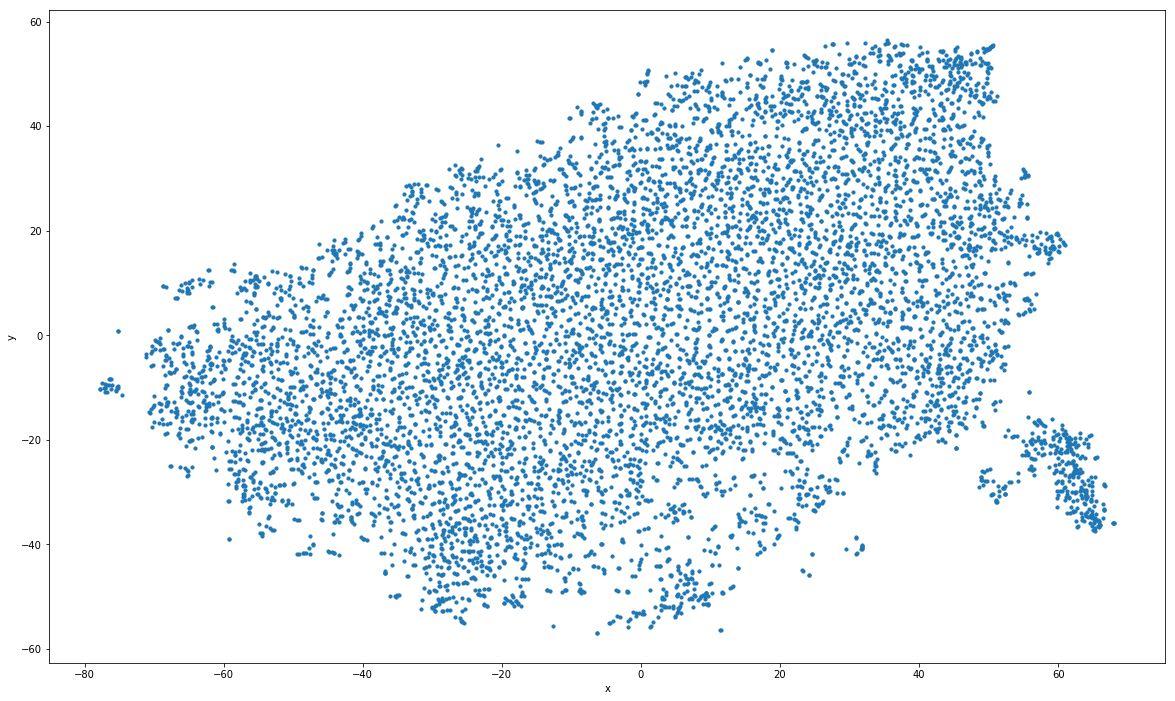

In [29]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [30]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [27]:
emotion2vec.most_similar('anxious')

[('bitter', 0.9811055660247803),
 ('aargh', 0.9808324575424194),
 ('lobster', 0.9807876348495483),
 ('sickness', 0.9802283644676208),
 ('uncomfortable', 0.9801842570304871),
 ('kyle', 0.9800786972045898),
 ('urgh', 0.9797723293304443),
 ('Belinda', 0.9793322086334229),
 ('bronchitis', 0.9791858196258545),
 ('cheesy', 0.9790263772010803)]

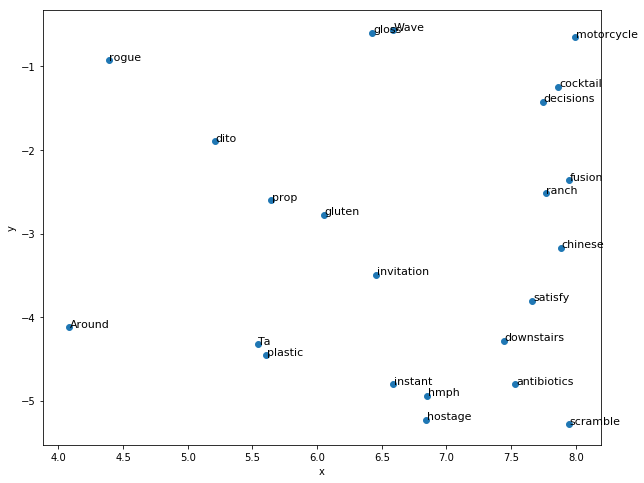

In [31]:
plot_region(x_bounds=(4.0, 8.2), y_bounds=(-5.5, -0.1))

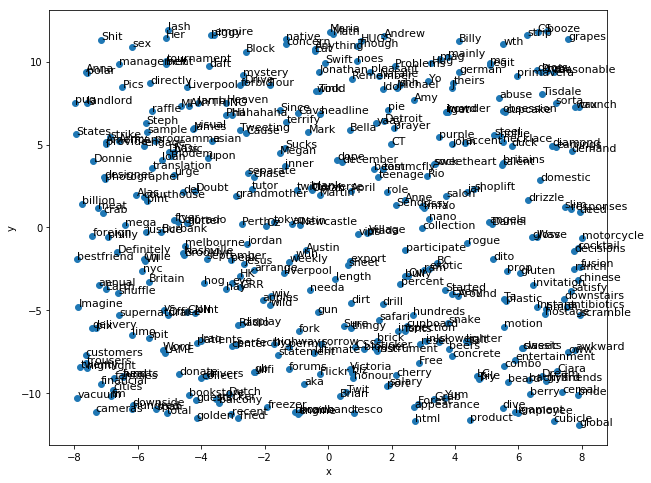

In [35]:
plot_region(x_bounds=(-8, 8), y_bounds=(-12, 12))